# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time
import warnings
warnings.filterwarnings("ignore")


# Creating the dataframe for execution

In [2]:
def create_dataset(filename):
    data = pd.read_csv(filename+".csv", header=None)
    #naming the columns
    names = ['x'+str(col+1) for col in data.columns[:-1]] + ['y']
    data.columns = names
    dataset = data.copy()
    #adding the x0 column to the dataset
    dataset['x0'] = 1
    dataset = dataset[['x0'] + list(dataset.columns[:-1])]
    return dataset


# HoldOut Method

In [3]:
def holdout_splitTrainTest(df_data, division_ratio = 0.7):
    '''splitting the data into training and testing set'''
    df_data = df_data.sample(frac = 1).reset_index(drop=True)
    training_number = int(division_ratio * len(df_data))
    train_x = df_data[:training_number][df_data.columns[:-1]]
    train_y = df_data[:training_number][df_data.columns[-1]]

    test_x = df_data[training_number:][df_data.columns[:-1]]
    test_y = df_data[training_number:][df_data.columns[-1]]

    train_y = np.matrix(train_y).reshape(-1,1)
    test_y = np.matrix(test_y).reshape(-1,1)

    return train_x, train_y, test_x, test_y
    

# K-Fold data Split

In [102]:
def kfold_splitTrainTest(df_data, folds = 5):
    '''splitting the data into training and testing set'''
    df_data = df_data.sample(frac = 1).reset_index(drop=True)
    fold_size = int(len(df_data)/folds)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(folds):
        if i == 0:
            train_x = df_data[:fold_size][df_data.columns[:-1]]
            train_y = df_data[:fold_size][df_data.columns[-1]]

            test_x = df_data[:fold_size][df_data.columns[:-1]]
            test_y = df_data[:fold_size][df_data.columns[-1]]
        else:
            train_x = pd.concat([train_x, df_data[i*fold_size:][df_data.columns[:-1]]])
            train_y = pd.concat([train_y, df_data[i*fold_size:][df_data.columns[-1]]])

            test_x = pd.concat([test_x, df_data[i*fold_size:][df_data.columns[:-1]]])
            test_y = pd.concat([test_y, df_data[i*fold_size:][df_data.columns[-1]]])

    train_y = np.matrix(train_y).reshape(-1,1)
    test_y = np.matrix(test_y).reshape(-1,1)

    return train_x, train_y, test_x, test_y

# Normalizing the data

In [5]:
def normalise(train_x, test_x):
    '''normalising the data'''
    for col in train_x.columns[1:]:
        minimum = train_x[col].min()
        diff = train_x[col].max() - minimum

        train_x[col] = (train_x[col] - minimum) / diff 
        test_x[col] = (test_x[col] - minimum) / diff

    return train_x, test_x

# Least Square Method and RMSE

In [6]:
def Least_Square(x, y, w):
    '''calculating the least square error --> Cost Function'''
    # y = np.matrix(y)
    y_pred = np.matmul(x,w)
    error = np.sum(np.square(y_pred - y))/2
    return error

def rmse(y, ypred):
    '''calculating the mean squared error'''
    return np.sqrt(np.mean(np.square(y - ypred))/len(y))

# Gradient Descent Algorithm

In [7]:
def batch_gradient_descent(train_x, train_y, alpha, epsilon):
    '''batch gradient descent'''
    w_init = np.zeros(train_x.shape[1]).reshape(-1,1)
    train_x = np.matrix(train_x)
    w_h = []
    cost_list = []
    w_old = w_init + 1

    while np.linalg.norm(w_old - w_init) > epsilon:
        w_old = w_init
        w_init = w_init - alpha * np.matmul(train_x.T, np.matmul(train_x, w_init) - train_y)
        w_h.append(w_init)
        cost_list.append(Least_Square(train_x, train_y, w_init))

    return w_init, w_h, cost_list

def stochastic_gradient_descent(train_x, train_y, alpha, epsilon):
    '''stochastic gradient descent'''
    w_init = np.zeros(train_x.shape[1]).reshape(-1,1)
    train_x = np.matrix(train_x)
    w_h = []
    cost_list = []
    w_old = w_init + 1

    while np.linalg.norm(w_old - w_init) > epsilon:
        w_old = w_init
        for i in range(len(train_x)):
            w_init = w_init - alpha * np.matmul(train_x[i].T, np.matmul(train_x[i], w_init) - train_y[i])
            w_h.append(w_init)
            cost_list.append(Least_Square(train_x, train_y, w_init))
        # train_x = train_x.sample(frac = 1).reset_index(drop=True)

    return w_init, w_h, cost_list



# Cross Validation

In [8]:
def monteCarloCrossvalidation(k, dataset):
    '''monte carlo cross validation'''
    alpha_list = [0.01, 0.002, 0.03, 0.001, 0.674]
    rmse_list = []
    
    epsilon = 1e-6
    for i in range(k):
        rmse_list.clear()
        for alpha in alpha_list:  
            #performiong holdout split
            train_x, train_y, test_x, test_y = holdout_splitTrainTest(dataset, 0.7)
            
            #normalizing the train and test data
            train_x, test_x = normalise(train_x, test_x)

            #performing schoastic gradient descent on training data
            w, w_h, j_w = stochastic_gradient_descent(train_x, train_y, alpha, epsilon)

            #predicting the test data
            test_x = np.matrix(test_x)
            y_pred = np.matmul(test_x,w)
            rmse_error = rmse(test_y, y_pred)
            print(f"alpha : {alpha}, rmse_error : {rmse_error}")
            rmse_list.append(rmse_error)

        #plotting the rmse vs alpha graph
        plt.scatter(alpha_list, rmse_list, marker='x', color='r')
        plt.plot(alpha_list, rmse_list, color='b')
        plt.xlabel('alpha')
        plt.ylabel('rmse')
        plt.show()
        print("---------------------------------------------------")

    return 0

# k-fold cross validation
def kfold_cross_validation(k, dataset):
    '''k-fold cross validation'''
    alpha_list = [0.01, 0.002, 0.03, 0.001, 0.674]
    rmse_list = []
    # splitting the data into k folds   
    train_x, train_y, test_x, test_y = kfold_splitTrainTest(dataset, k)
    #normalizing the train and test data
    train_x, test_x = normalise(train_x, test_x)
    epsilon = 1e-6

    for alpha in alpha_list:  
        #performing schoastic gradient descent on training data
        w, w_h, j_w = stochastic_gradient_descent(train_x, train_y, alpha, epsilon)

        #predicting the test data
        test_x = np.matrix(test_x)
        y_pred = np.matmul(test_x,w)
        rmse_error = rmse(test_y, y_pred)
        print(f"alpha : {alpha}, rmse_error : {rmse_error}")
        rmse_list.append(rmse_error)

    #plotting the rmse vs alpha graph
    plt.scatter(alpha_list, rmse_list, marker='x', color='r')
    plt.plot(alpha_list, rmse_list, color='b')
    plt.xlabel('alpha')
    plt.ylabel('rmse')
    plt.show()
    print("---------------------------------------------------")

    return 0


alpha : 0.01, rmse_error : 3.662531438609505e-06
alpha : 0.002, rmse_error : 3.6281629454232852e-06
alpha : 0.03, rmse_error : 3.7505465396223463e-06
alpha : 0.001, rmse_error : 3.663059991296282e-06
alpha : 0.674, rmse_error : 9.492939591168834e-06


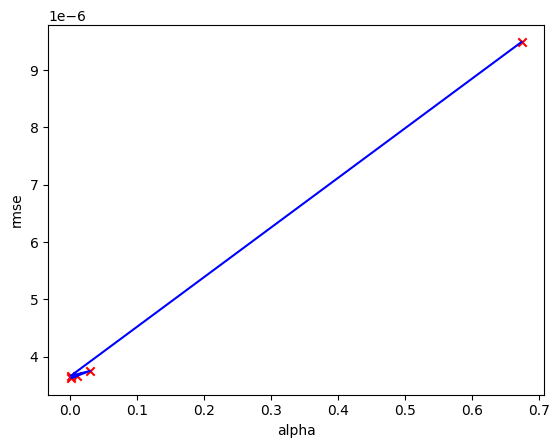

---------------------------------------------------


0

In [103]:
# monteCarloCrossvalidation(2, dataset1)
kfold_cross_validation(5, dataset1)

# 1. Analyze Data 1 and Data 2 using linear regression

(a) Plot J(w)against iteration.

(b) Plot J(w)against w obtained in each iteration for Data 1.

(c) Plot the hyperplane that generates the data.

(d) Describe the experimental procedures used.

(e) Report the parameters of the model.

ANALYZING DATA 1 :--------------------->

In [83]:
filename = 'data1'
dataset1 = create_dataset(filename)
dataset1.head()

,x0,x1,y
0,1,0.45478,3.18270
1,1,-0.31160,0.34708
2,1,0.94642,5.00180
3,1,0.33790,2.75020
4,1,0.23853,2.38260


(a) Plot J(w)against iteration



In [101]:
folds =5
fold_size = int(len(dataset1)/folds)
train_x = []
for i in range(folds):
    if i == 0:
        train_x = dataset1[:fold_size][dataset1.columns[:-1]]
    else:
        # d = dataset1[i*fold_size:][:fold_size]
        train_x = pd.concat([train_x, dataset1[i*fold_size:][dataset1.columns[:-1]]])
        print(train_x.shape)

    print(".....................................................")

dataset1[i*fold_size:][:fold_size]

.....................................................
(200, 2)
.....................................................
(320, 2)
.....................................................
(400, 2)
.....................................................
(440, 2)
.....................................................


,x0,x1,y
160,1,-0.228100,0.656040
161,1,-1.058300,-2.415900
162,1,1.641600,7.573800
163,1,-2.429300,-7.488300
164,1,1.484400,6.992100
165,1,1.050900,5.388300
166,1,-0.107960,1.100500
167,1,-0.933170,-1.952700
168,1,-1.709300,-4.824300
169,1,0.658360,3.935900


Rmse : 9.875843426914562e-06


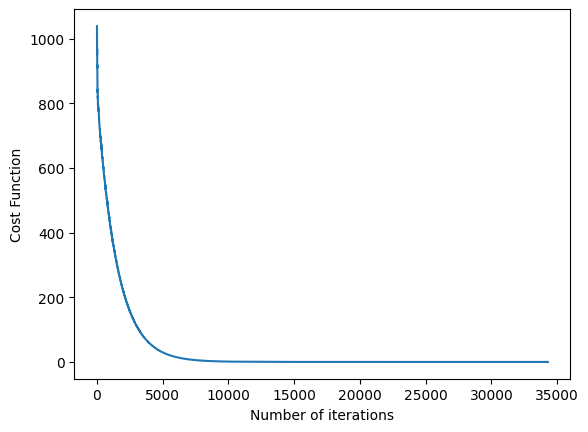

In [57]:
train_x, train_y, test_x, test_y = holdout_splitTrainTest(dataset1, 0.7)
train_x, test_x = normalise(train_x, test_x)
alpha = 0.01
epsilon = 1e-5

w1, w1_h, j_w1 = stochastic_gradient_descent(train_x, train_y, alpha, epsilon)

y_pred1 = np.matmul(test_x,w1)
print(f"Rmse : {rmse(test_y,y_pred1)}")

# plotting the cost function against the number of iterations
plt.plot(j_w1)
plt.xlabel('Number of iterations')
plt.ylabel('Cost Function')
plt.show()

(b) Plot J(w) against w_h obtained in each iteration for Data1


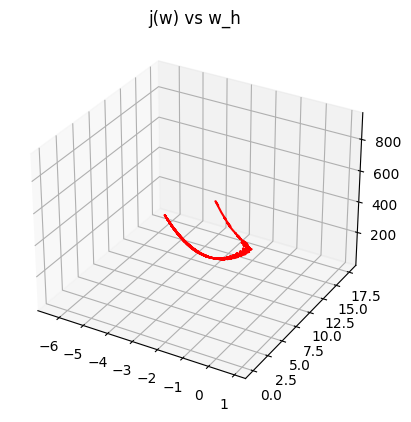

In [12]:
w1_h = np.array(w1_h)
w1_h = w1_h.reshape(w1_h.shape[0], w1_h.shape[1])   

#take each column of w_h and plot it against the j_w
ax = plt.axes(projection='3d')
ax.plot3D([w[0] for w in w1_h], [w[1] for w in w1_h], j_w1, color='r')
plt.title("j(w) vs w_h")
plt.show()

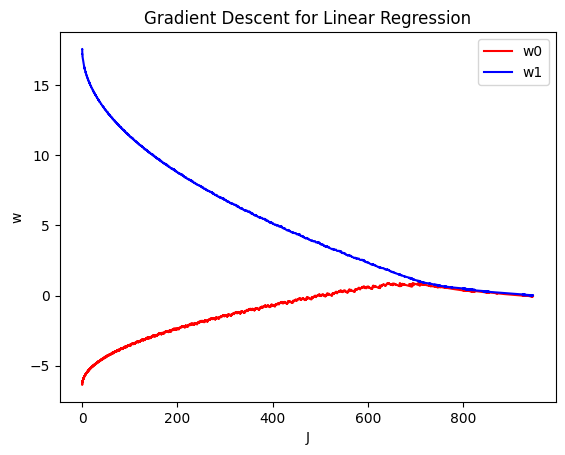

In [13]:
plt.plot(j_w1, [w[0] for w in w1_h], 'r', label='w0')
plt.plot(j_w1, [w[1] for w in w1_h], 'b', label='w1')
plt.xlabel('J')
plt.ylabel('w')
plt.title("Gradient Descent for Linear Regression")
plt.legend()
plt.show()

(c) Plot the hyperplane that generates the data.


Test Rmse value : 0.6712227639913941


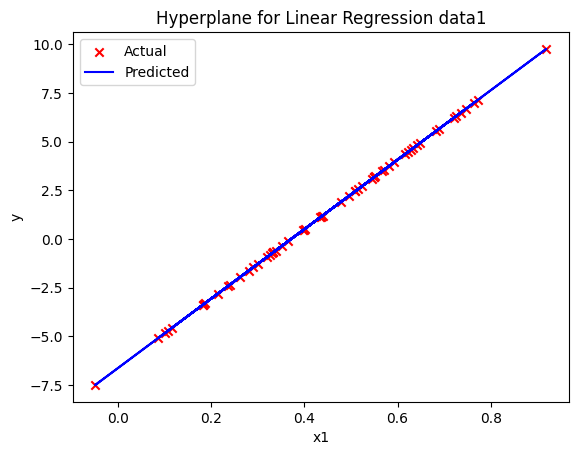

In [60]:
 #plotting the hyperplane and the data of the test dataset
y_pred1 = [float(y) for y in np.matrix(np.matmul(test_x,w1))]
rmse_error = rmse(test_y, y_pred1)
test_y_list1 = list(test_y)
test_y_list1 = [float(y) for y in test_y_list1]
pred_y_list1 = [y for y in y_pred1]

print(f"Test Rmse value : {rmse_error}")

x1_list = [float(x) for x in test_x['x1']]

plt.scatter(x1_list, test_y_list1, color='r', marker='x', label = "Actual")
plt.plot(x1_list, pred_y_list1, color='b',label = "Predicted")
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Hyperplane for Linear Regression data1")
plt.legend()
plt.show()


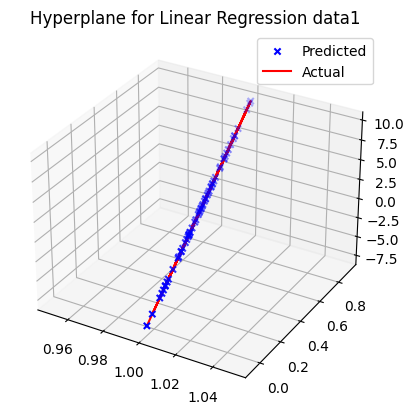

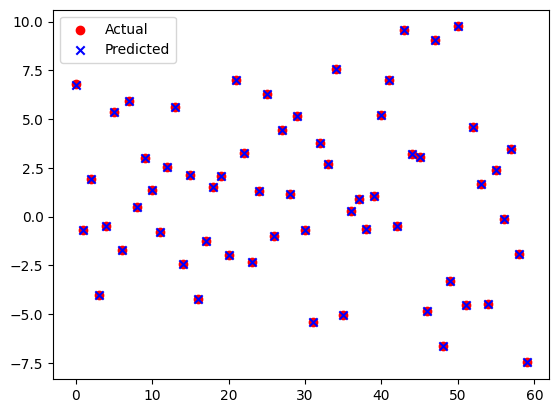

In [15]:
ax = plt.axes(projection='3d')
ax.scatter3D(test_x['x0'],test_x['x1'], test_y_list1, color='b', label = "Predicted", marker='x')
ax.plot3D(test_x['x0'],test_x['x1'], pred_y_list1, color='red', label = "Actual")
plt.legend()
plt.title("Hyperplane for Linear Regression data1")
plt.show()

plt.scatter([i for i in range(len(test_x['x1']))], test_y_list1, color='r', label = "Actual")
plt.scatter([i for i in range(len(test_x['x1']))], pred_y_list1, marker='x', color='b',label = "Predicted")
plt.legend()


(d) Describe the experimental procedures used.

In [16]:
'''The experimental procedure is as follows:
1. first we take the dataset using pandas
2. then we split the dataset into training and testing set
3. then we normalize the training and testing set
4. then we perform gradient descent on the training set (Schocastic Gradient Descent) or (Batch Gradient Descent))
5. then we predict the test set using the weights obtained from the training set
6. then we calculate the rmse error between the predicted and the actual values of the test set
7. then we plot the cost function against the number of iterations
8. then we plot the hyperplane and the data of the test dataset
9. then we calculate the rmse error between the predicted and the actual values of the test set'''

'The experimental procedure is as follows:\n1. first we take the dataset using pandas\n2. then we split the dataset into training and testing set\n3. then we normalize the training and testing set\n4. then we perform gradient descent on the training set (Schocastic Gradient Descent) or (Batch Gradient Descent))\n5. then we predict the test set using the weights obtained from the training set\n6. then we calculate the rmse error between the predicted and the actual values of the test set\n7. then we plot the cost function against the number of iterations\n8. then we plot the hyperplane and the data of the test dataset\n9. then we calculate the rmse error between the predicted and the actual values of the test set'

(e) Report the parameters of the model.

In [17]:
print(f"The Parameters of the model is : \n{w1}")

The Parameters of the model is : 
[[-6.3624255 ]
 [17.55705312]]



ANALYZING DATA2 : ------------------->

   x0   x1   x2       y
0   1  607  379 -1318.4
1   1  402  746  -867.4
2   1  935  175 -2040.0
3   1  963  809 -2101.6
4   1  486   17 -1052.2


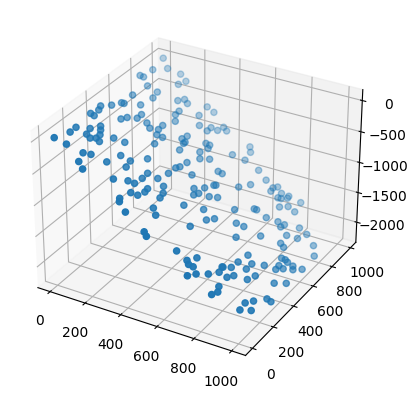

In [18]:
filename = 'data2'
dataset2 = create_dataset(filename)
print(dataset2.head())

'''visualize the dataset'''
data2_x = dataset2[dataset2.columns[:-1]]
data2_y = dataset2[dataset2.columns[-1]]
fig = plt.figure
ax = plt.axes(projection='3d')
ax.scatter3D(data2_x['x1'], data2_x['x2'], data2_y)
plt.show()

(a) Plot J(w)against iteration



Rmse : 0.002369440755227361


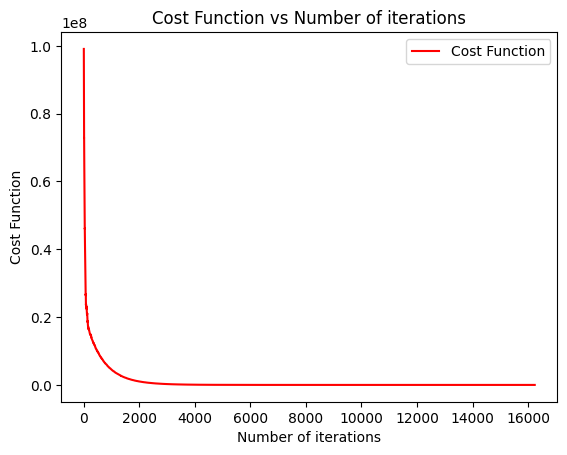

In [19]:
train_x, train_y, test_x, test_y = holdout_splitTrainTest(dataset2, 0.7)
train_x, test_x = normalise(train_x, test_x)

# training the model
learning_rate = 0.01
epsilon = 1e-2
w, w_h, j_w = stochastic_gradient_descent(train_x, train_y, learning_rate, epsilon)

y_pred = np.matmul(train_x, w)
print(f"Rmse : {rmse(train_y ,y_pred)}")

# print(test_x['x1'].shape)

# plotting the cost function against the number of iterations
plt.plot(j_w, color='r', label='Cost Function')
plt.title("Cost Function vs Number of iterations")
plt.xlabel('Number of iterations')
plt.ylabel('Cost Function')
plt.legend()
plt.show()

(c) Plot the hyperplane that generates the data.

Test Rmse value : 0.0040088267191516


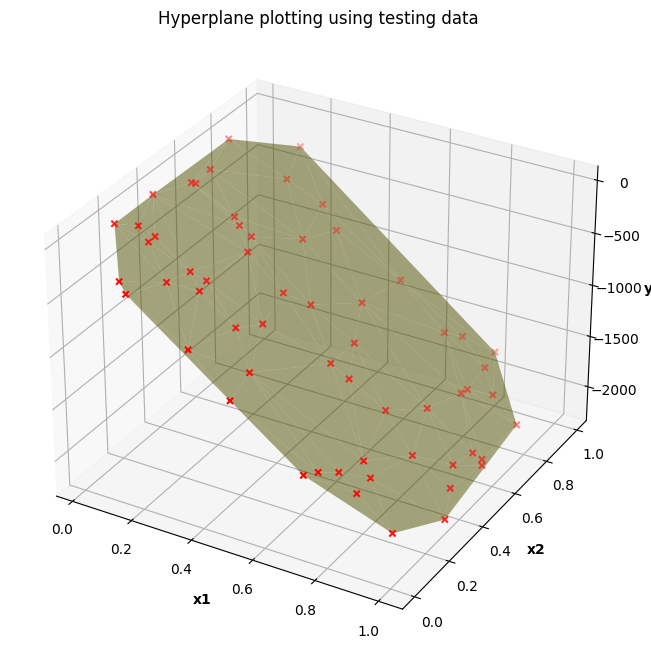

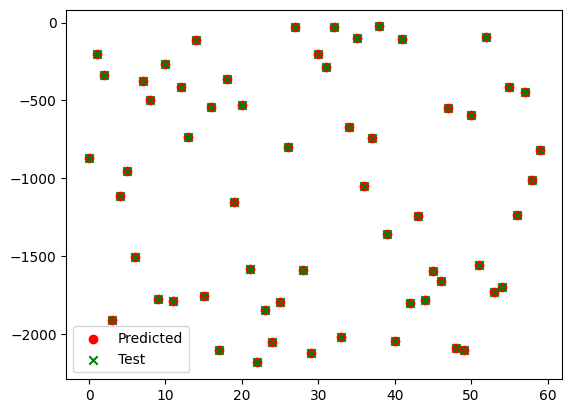

In [20]:
y_pred = np.matmul(test_x, w)

rmse_error = rmse(test_y, y_pred)
print(f"Test Rmse value : {rmse_error}")

test_y_list = list(test_y)
test_y_list = [float(y) for y in test_y_list]
pred_y_list = [float(y) for y in np.matrix(y_pred)]

x1_list = [float(x) for x in test_x['x1']]
x2_list = [float(x) for x in test_x['x2']]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.set_xlabel('x1', fontweight='bold')
ax.set_ylabel('x2', fontweight='bold')
ax.set_zlabel('y', fontweight='bold')
ax.scatter3D(x1_list, x2_list, test_y_list, color='r', marker='x', label = "Actual")
ax.plot_trisurf(x1_list, x2_list, pred_y_list, color='y',label = "Predicted", alpha=0.5)
plt.title('Hyperplane plotting using testing data')
plt.show()


plt.scatter([i for i in range(len(y_pred))],y_pred, c = 'red',label='Predicted')
plt.scatter([i for i in range(len(test_y_list))],test_y_list, marker='x', c = 'green',label='Test')
plt.legend()

(d) Describe the experimental procedures used.

In [21]:
'''The experimental procedure is as follows:
1. first we take the dataset using pandas
2. then we split the dataset into training and testing set
3. then we normalize the training and testing set
4. then we perform gradient descent on the training set (Schocastic Gradient Descent) or (Batch Gradient Descent))
5. then we predict the test set using the weights obtained from the training set
6. then we calculate the rmse error between the predicted and the actual values of the test set
7. then we plot the cost function against the number of iterations
8. then we plot the hyperplane and the data of the test dataset
9. then we calculate the rmse error between the predicted and the actual values of the test set'''

'The experimental procedure is as follows:\n1. first we take the dataset using pandas\n2. then we split the dataset into training and testing set\n3. then we normalize the training and testing set\n4. then we perform gradient descent on the training set (Schocastic Gradient Descent) or (Batch Gradient Descent))\n5. then we predict the test set using the weights obtained from the training set\n6. then we calculate the rmse error between the predicted and the actual values of the test set\n7. then we plot the cost function against the number of iterations\n8. then we plot the hyperplane and the data of the test dataset\n9. then we calculate the rmse error between the predicted and the actual values of the test set'

e) Report the parameters of the model.

In [22]:
print(f"The Parameters of the model is : \n{w}")

The Parameters of the model is : 
[[ 1.25286770e+01]
 [-2.18894066e+03]
 [ 7.41258245e-02]]


# 2. Analyze Data 3 using linear regression

(a) Find the parameters using direct method and iterative methods.

(b) Compare the time taken and space requirements of two approaches.

(c) Describe the experimental procedures used.

(d) Report the values of the hyperparameters and parameters of the model.

(e) Analyze the performance of the model.

ANALYZING DATA-3 :------------------------------------------->

In [23]:
filename = 'data3'
dataset3 = create_dataset(filename)
print(dataset3.head())

   x0       x1       x2       x3        x4       x5       x6       x7  \
0   1 -0.20194  1.20030  1.58980 -1.598800 -0.16687  0.18943 -1.20490   
1   1  0.86107 -0.10728 -2.03180 -0.846320  0.14752  0.11857  0.85306   
2   1  1.55820  0.61950  2.35520  0.044202 -1.07630  2.44090 -0.30732   
3   1 -0.12968  1.09100  0.76404 -0.057685 -0.10341  0.67060  0.24801   
4   1 -0.81777 -0.44203 -2.11470 -0.122620 -0.31536 -0.67953  0.60266   

        x8       x9  ...      x42      x43      x44       x45       x46  \
0  0.33534 -0.69619  ... -1.42180  0.78505  0.70262 -2.353700  1.394700   
1 -0.59189 -0.26797  ...  0.48337  0.91948  0.68379 -0.253330  0.032124   
2  0.62645 -0.33881  ...  0.21967 -0.23811  0.70586  2.390900  0.729670   
3 -0.69294  1.32640  ...  1.11410  0.99151  0.17876  0.027139  0.510250   
4 -0.83188 -0.44757  ...  0.52212 -0.19912  0.29868 -0.556280  1.257500   

        x47       x48       x49      x50        y  
0  0.350110  2.084900 -1.487400 -0.62893   52.000  
1  1.1

(a) Find the parameters using direct method and iterative methods.

In [24]:
# using direct Method : w = (X.T * X)^-1 * X.T * y

x = dataset3[dataset3.columns[:-1]]
y = dataset3[dataset3.columns[-1]]

x = np.matrix(x)
y = np.matrix(y).T

d_t1 =time.time()
w3_d = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T), y)
d_t2 = time.time()

print(f"values of hyperparameters using direct method w3 : \n{w3_d.T}")

values of hyperparameters using direct method w3 : 
[[1.17499365e-04 3.00012352e+00 1.30002413e+01 4.00006608e+00
  7.99989876e+00 1.10001828e+01 1.79999616e+01 1.40001142e+01
  1.59998704e+01 2.99990180e+00 1.10001483e+01 1.80002202e+01
  3.00015611e+00 1.29999149e+01 2.00009267e+00 8.99993966e+00
  1.50001011e+01 3.00002222e+00 1.69999253e+01 1.29999781e+01
  1.79999930e+01 1.30000006e+01 8.99993925e+00 1.30000514e+01
  1.00000901e+01 2.00018564e+00 1.30002698e+01 1.99999128e+01
  1.00004043e+01 1.30000325e+01 1.19999244e+01 5.00015111e+00
  1.40003348e+01 4.00022142e+00 1.60003623e+01 5.00022019e+00
  3.99985959e+00 1.49999665e+01 5.99981920e+00 4.00008941e+00
  1.29998624e+01 6.00010566e+00 6.00016352e+00 1.69997806e+01
  7.99999846e+00 3.00013981e+00 3.99962459e+00 8.00006693e+00
  1.80001574e+01 1.19998188e+01 6.00026240e+00]]


In [25]:
train_x3, train_y3, test_x3, test_y3 = holdout_splitTrainTest(dataset3, 0.7)
train_x3, test_x3 = normalise(train_x3, test_x3)
learning_rate = 0.01
epsilon = 1e-5

i_t1 = time.time()  
w3, w3_h, j_w3 = stochastic_gradient_descent(train_x3, train_y3, learning_rate, epsilon)
i_t2 = time.time()

print(f"values of hyperparameters using iterative method w3 : \n{w3.T}")

values of hyperparameters using iterative method w3 : 
[[-1267.82909471    15.18356163    56.80048299    24.65792968
     32.57703964    53.42172752    77.79276029    65.8097448
     70.73499303    15.14966955    53.55116411    85.20997505
     19.08707706    56.86626895    12.84264757    39.07439815
     78.56078368    12.58599251    81.02265746    67.19197857
     92.05483216    73.87114833    45.89115916    67.36868914
     51.08970983    10.54500185    69.61101519   100.48943
     49.18460335    80.09863488    59.54498123    25.51330066
     58.28613759    19.46293724    88.30680683    22.64491193
     18.41570753   102.75443485    28.82629268    22.73740275
     61.17780823    34.5524372     30.58055335    97.37386121
     36.28848919    17.16762405    22.93107429    37.6831032
     91.3342848     71.33870001    32.3052434 ]]


(b) Compare the time taken and space requirements of two approaches.

In [26]:
print(f"time taken for direct method : {d_t2 - d_t1}")
print(f"time taken for iterative method : {i_t2 - i_t1}")

time taken for direct method : 0.06813645362854004
time taken for iterative method : 34.614093542099


(c) Describe the experimental procedures used.

In [27]:
'''The experimental procedures used are as follows:

1. The data is loaded from the csv file using pandas library.
2. The data is split into training (70%) and testing (30%) data.
3. Learning rate is set to 0.01.
4. The linear regression model is trained.
5. J(w) is calculated using the root mean square error formula.
6. J(w) is plotted against iteration.
7. J(w) is plotted against w obtained in each iteration.
8. Predicted values are obtained using the trained model's w.
9. The hyperplane that generates the data is plotted.'''

"The experimental procedures used are as follows:\n\n1. The data is loaded from the csv file using pandas library.\n2. The data is split into training (70%) and testing (30%) data.\n3. Learning rate is set to 0.01.\n4. The linear regression model is trained.\n5. J(w) is calculated using the root mean square error formula.\n6. J(w) is plotted against iteration.\n7. J(w) is plotted against w obtained in each iteration.\n8. Predicted values are obtained using the trained model's w.\n9. The hyperplane that generates the data is plotted."

(d) Report the values of the hyperparameters and parameters of the model.

In [28]:
print(f'The hyperparameter of the model used in iterative method: \nlr={learning_rate}, \nepsilon={epsilon}')
print()
print(f"values of parameters using direct method w3_d : \n{w3_d.T}")
print()
print(f"values of parameters using iterative method w3 : \n{w3.T}")

The hyperparameter of the model used in iterative method: 
lr=0.01, 
epsilon=1e-05

values of parameters using direct method w3_d : 
[[1.17499365e-04 3.00012352e+00 1.30002413e+01 4.00006608e+00
  7.99989876e+00 1.10001828e+01 1.79999616e+01 1.40001142e+01
  1.59998704e+01 2.99990180e+00 1.10001483e+01 1.80002202e+01
  3.00015611e+00 1.29999149e+01 2.00009267e+00 8.99993966e+00
  1.50001011e+01 3.00002222e+00 1.69999253e+01 1.29999781e+01
  1.79999930e+01 1.30000006e+01 8.99993925e+00 1.30000514e+01
  1.00000901e+01 2.00018564e+00 1.30002698e+01 1.99999128e+01
  1.00004043e+01 1.30000325e+01 1.19999244e+01 5.00015111e+00
  1.40003348e+01 4.00022142e+00 1.60003623e+01 5.00022019e+00
  3.99985959e+00 1.49999665e+01 5.99981920e+00 4.00008941e+00
  1.29998624e+01 6.00010566e+00 6.00016352e+00 1.69997806e+01
  7.99999846e+00 3.00013981e+00 3.99962459e+00 8.00006693e+00
  1.80001574e+01 1.19998188e+01 6.00026240e+00]]

values of parameters using iterative method w3 : 
[[-1267.82909471    15.

(e) Analyze the performance of the model.

In [29]:
#performance of the model through ditrect method
y_pred3 = np.matmul(test_x3, w3_d)
print(f"Rmse of direct method : {rmse(test_y3 ,y_pred3)}")

#performance of the model through iterative method
y_pred3_1 = np.matmul(test_x3, w3)
print(f"Rmse of iterative method : {rmse(test_y3 ,y_pred3_1)}")

Rmse of direct method : 32.938644885059276
Rmse of iterative method : 0.0003478284637001365
